# Mafat wifi people counter 

### Includes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import math
import scipy

### Get data from csv file

In [3]:
file_path = '/content/drive/MyDrive/mafat/mafat_wifi_challenge_training_set_v1.csv'

In [4]:
data = pd.read_csv(file_path)

### Show data

In [5]:
room = data[data['Room_Num'] == 2].copy()
room.loc[room['Num_People'] != 0, 'Num_People'] = 1

In [6]:
num_devices = room['Device_ID'].unique().shape[0]

#### Raw data

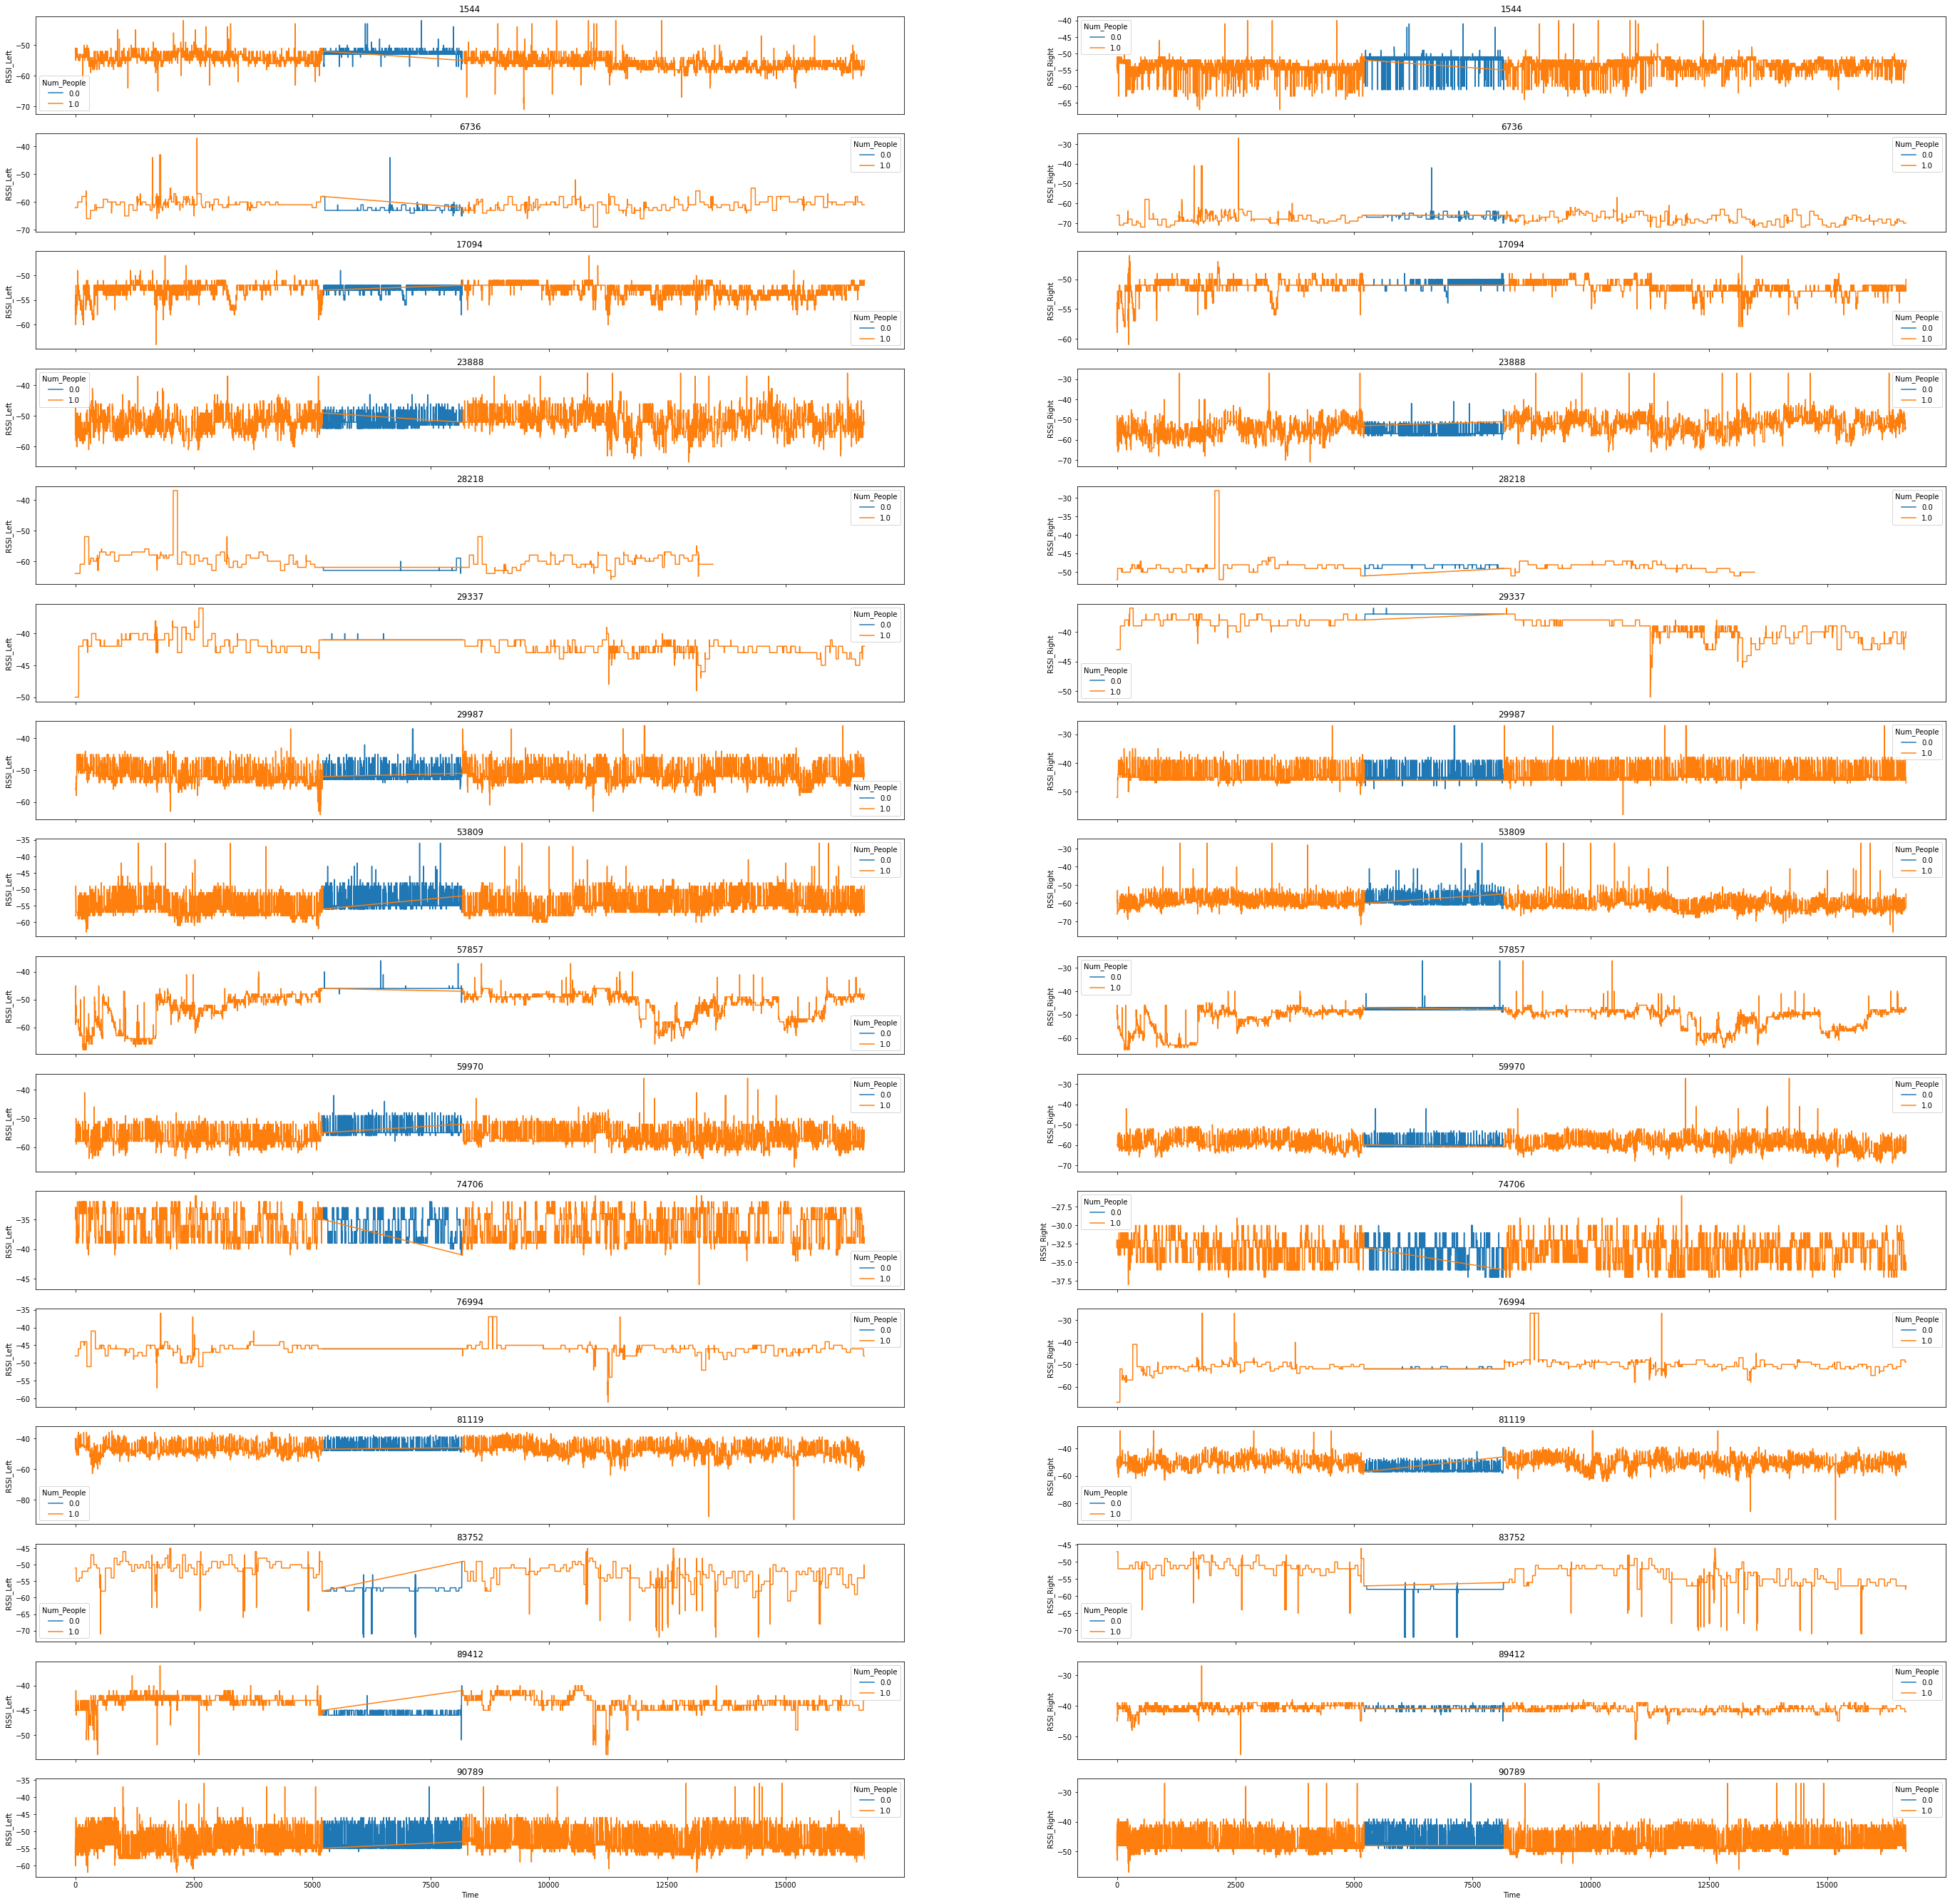

In [ ]:
fig, axes = plt.subplots(num_devices, 2, sharex=True, figsize=(48,48))
index = 0
for name, group in room.groupby('Device_ID'):
    seaborn.lineplot(ax=axes[index][0], x=group['Time'], y=group['RSSI_Left'], hue=group['Num_People']).set_title(name)
    seaborn.lineplot(ax=axes[index][1], x=group['Time'], y=group['RSSI_Right'], hue=group['Num_People']).set_title(name)   
    index += 1

#### Kalman filter to clean the data from outliers

In [8]:
def kalman_filter(rssi):
    n_iter = rssi.shape[0]
    sz = (n_iter,) # size of array
    x =  rssi# truth value 
    z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 1**2 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = z[0]
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
    return xhat

In [9]:
def exponentialSmoothing(rssi):
    return rssi.ewm(com=0.5).mean()

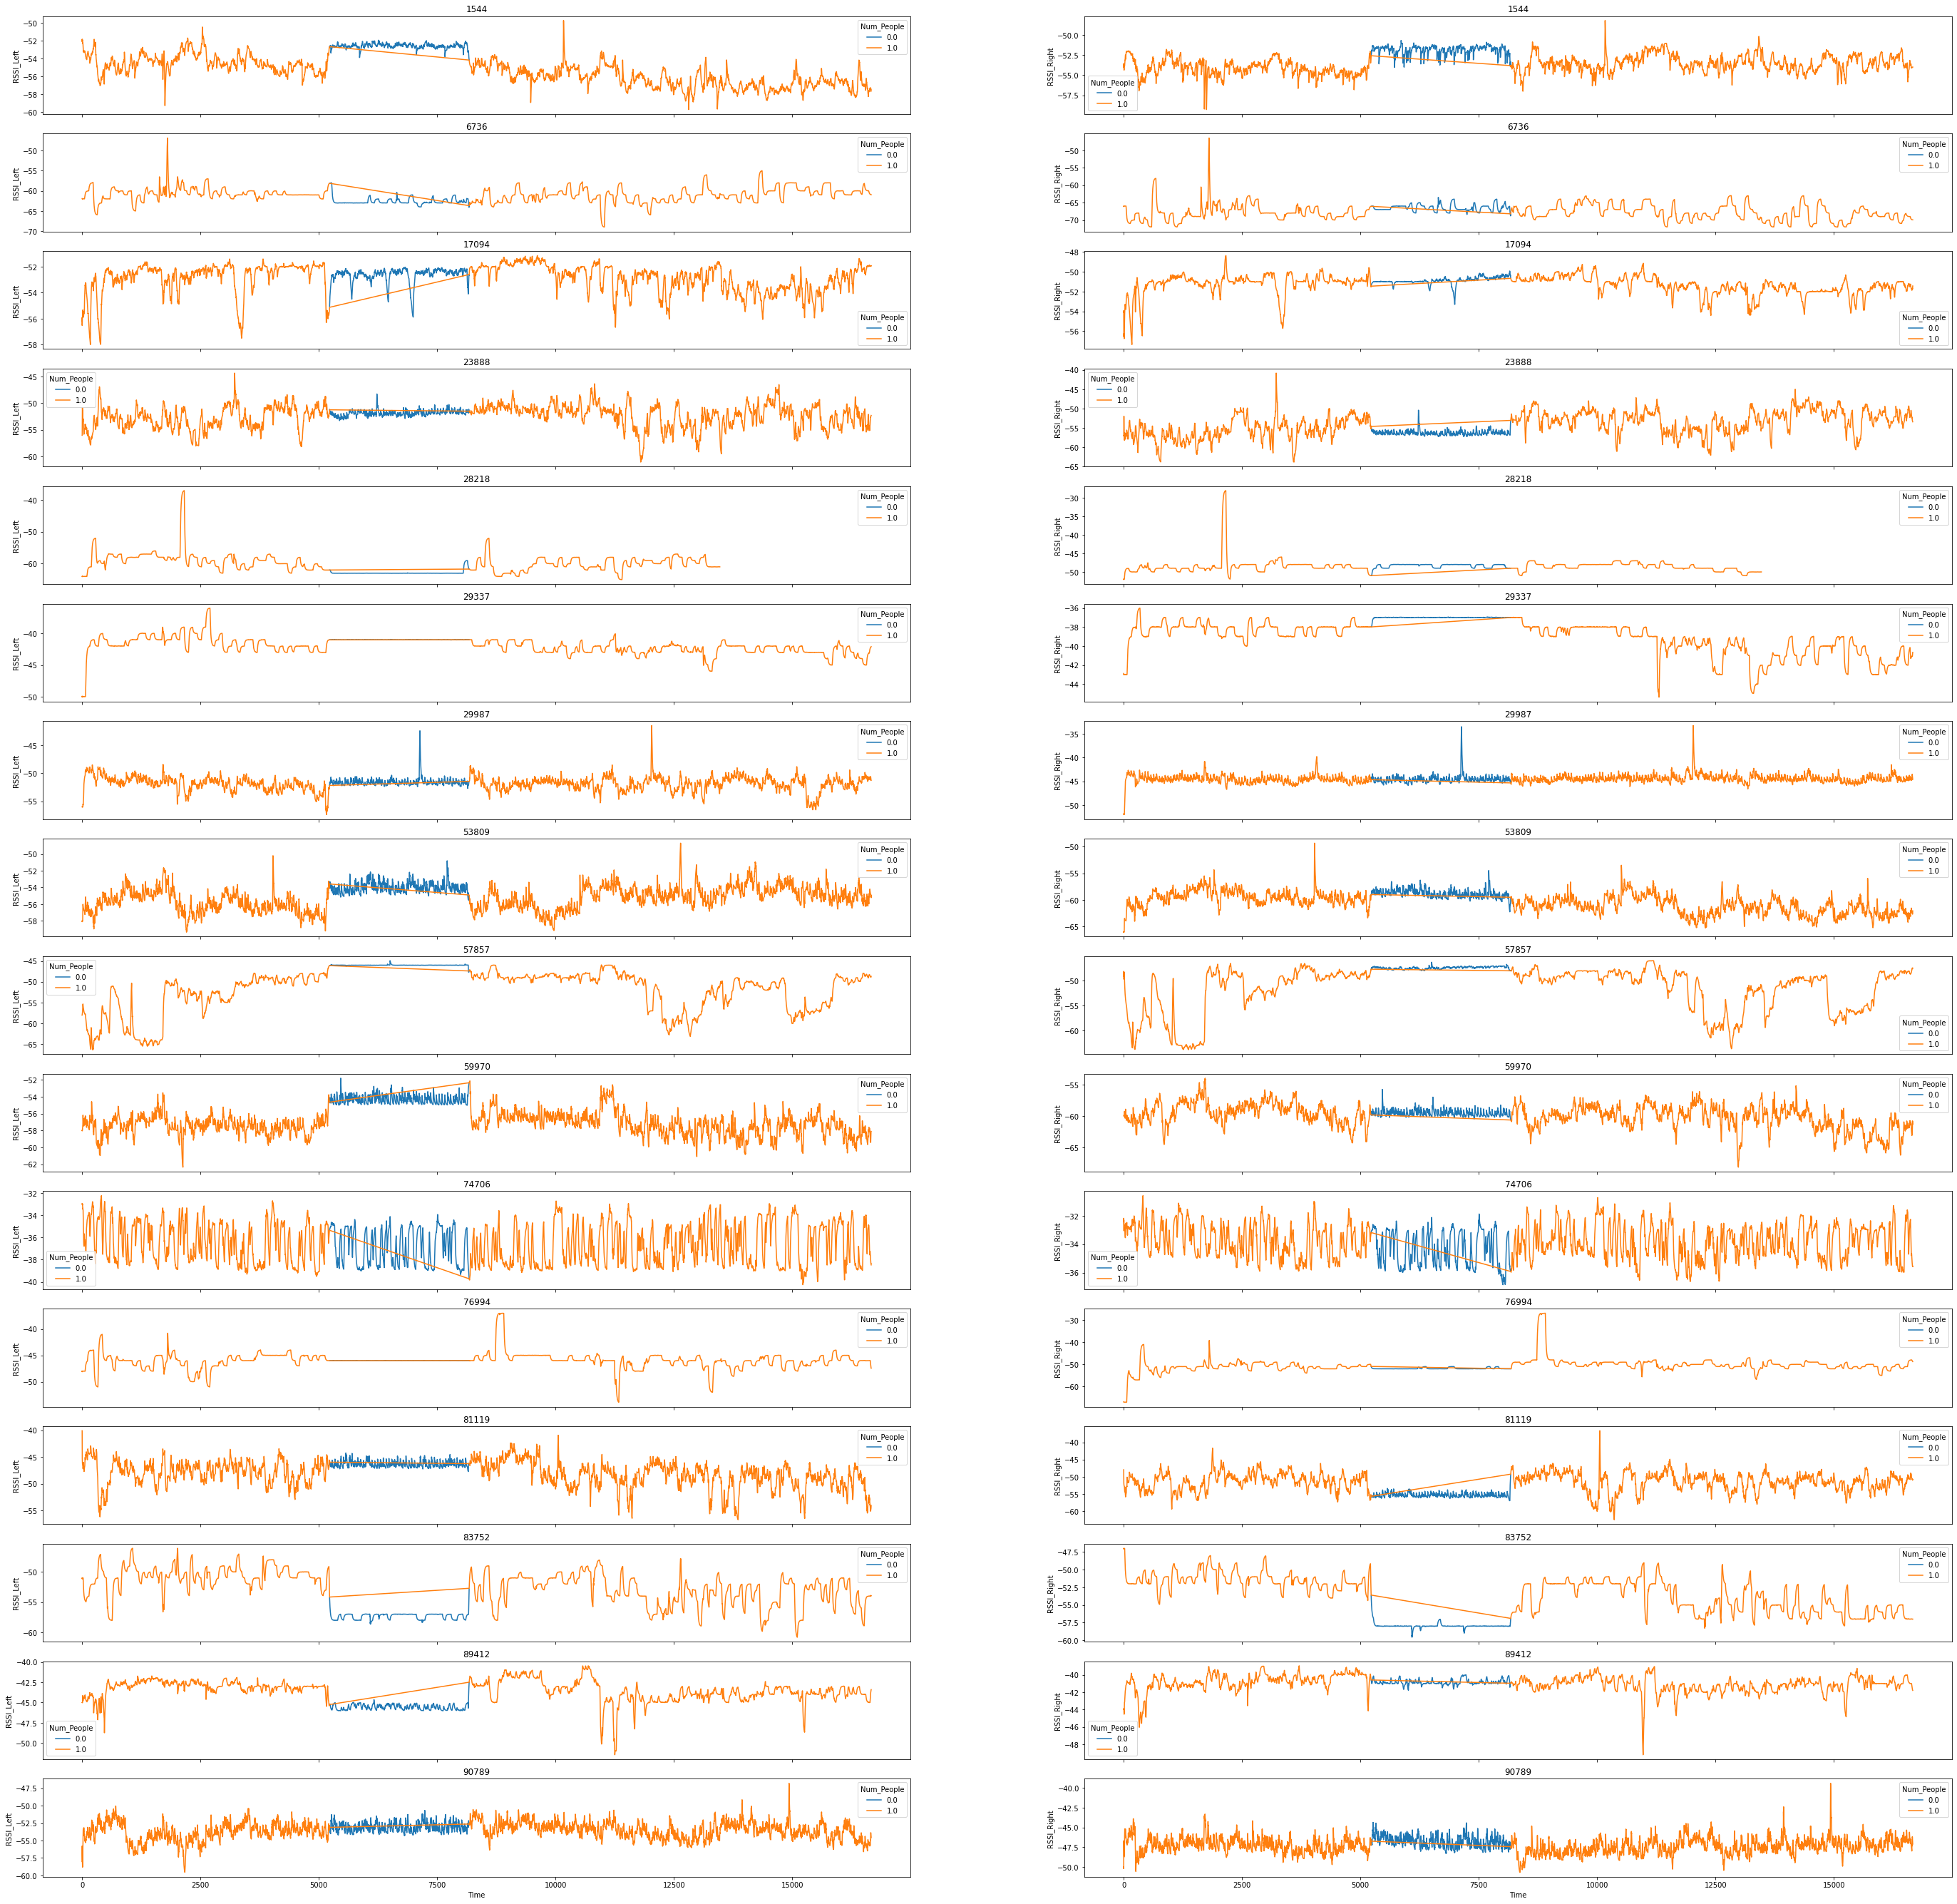

In [ ]:
fig, axes = plt.subplots(num_devices, 2, sharex=True, figsize=(48,48))
index = 0
for name, group in room.groupby('Device_ID'):
    group['RSSI_Left'] = kalman_filter(exponentialSmoothing(group.sort_values('Time')['RSSI_Left']))
    group['RSSI_Right'] = kalman_filter(exponentialSmoothing(group.sort_values('Time')['RSSI_Right']))
    seaborn.lineplot(ax=axes[index][0], x=group['Time'], y=group['RSSI_Left'], hue=group['Num_People']).set_title(name)
    seaborn.lineplot(ax=axes[index][1], x=group['Time'], y=group['RSSI_Right'], hue=group['Num_People']).set_title(name)   
    index += 1

#### get variance over time

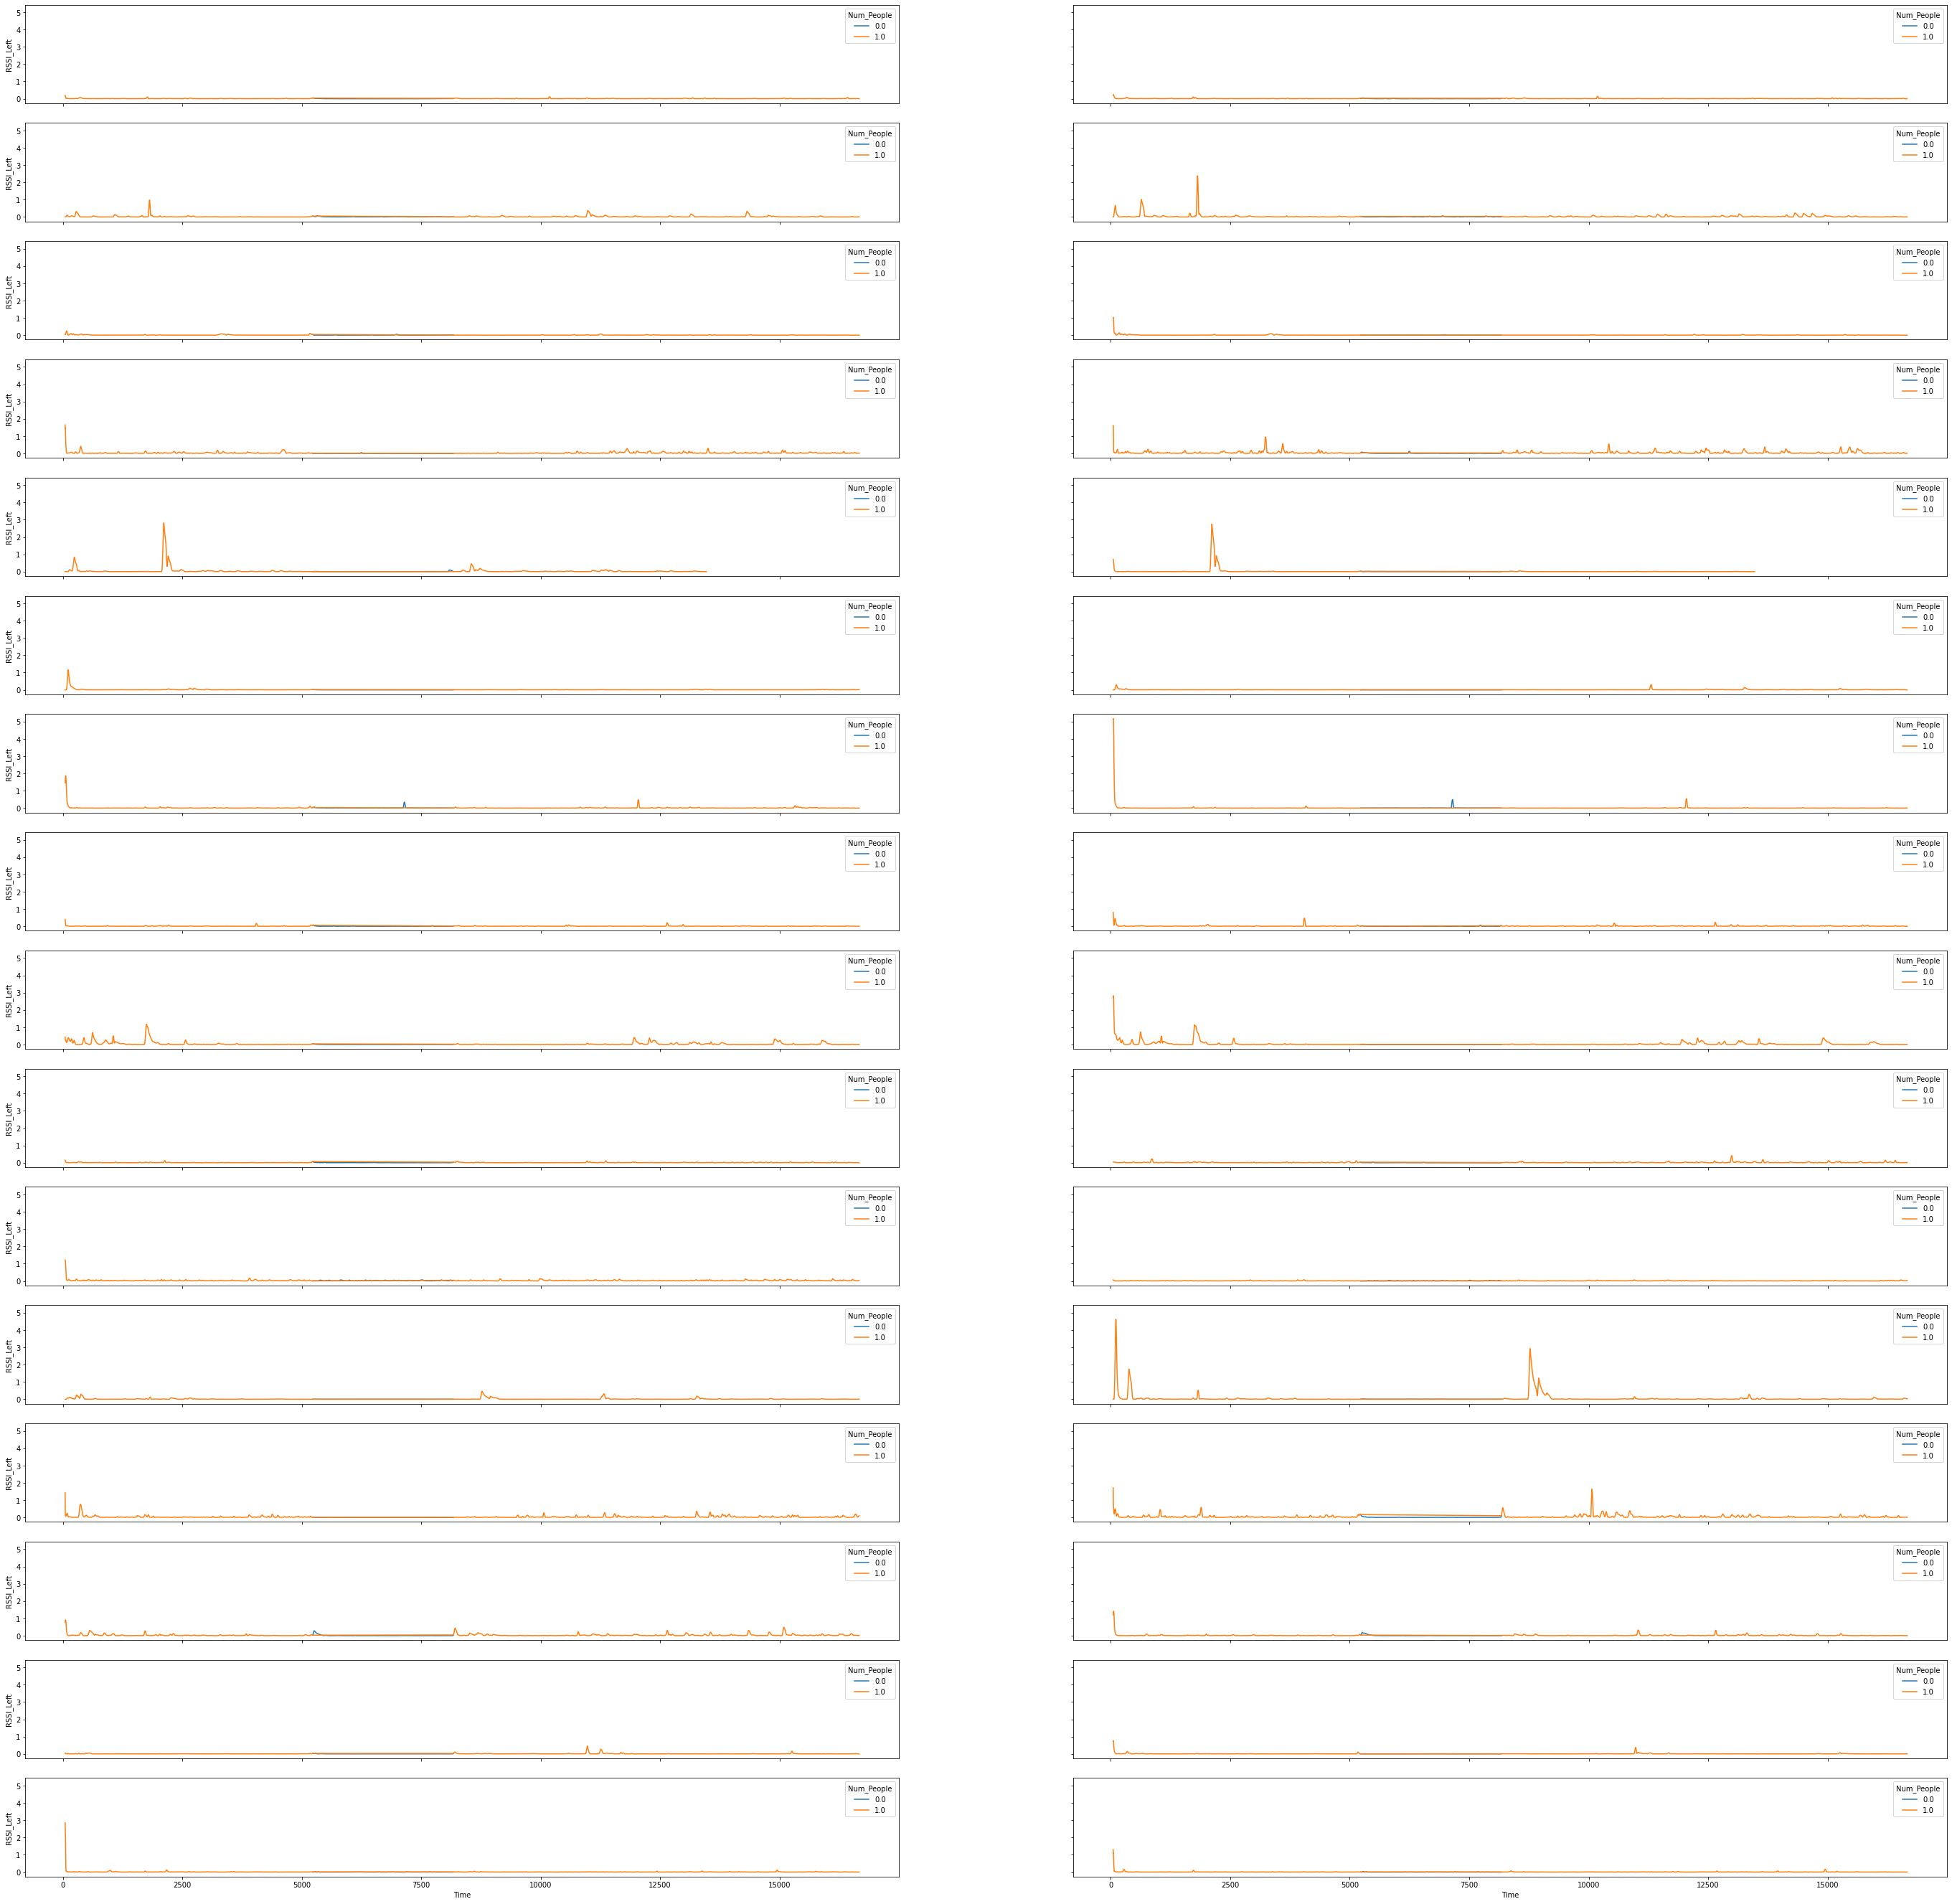

In [10]:
fig, axes = plt.subplots(num_devices, 2, sharex=True, sharey=True, figsize=(48,48))
index = 0
for name, group in room.groupby('Device_ID'):
    group['RSSI_Left'] = kalman_filter(group.sort_values('Time')['RSSI_Left'])
    group['RSSI_Right'] = kalman_filter(group.sort_values('Time')['RSSI_Right'])
    group_var = group.rolling(100, on='Time')[['RSSI_Left', 'RSSI_Right']].var()
    seaborn.lineplot(ax=axes[index][0], x=group['Time'], y=group_var['RSSI_Left'], hue=group['Num_People'])
    seaborn.lineplot(ax=axes[index][1], x=group['Time'], y=group_var['RSSI_Right'], hue=group['Num_People'])   
    index += 1

Text(0.5, 1.0, 'right rssi avg')

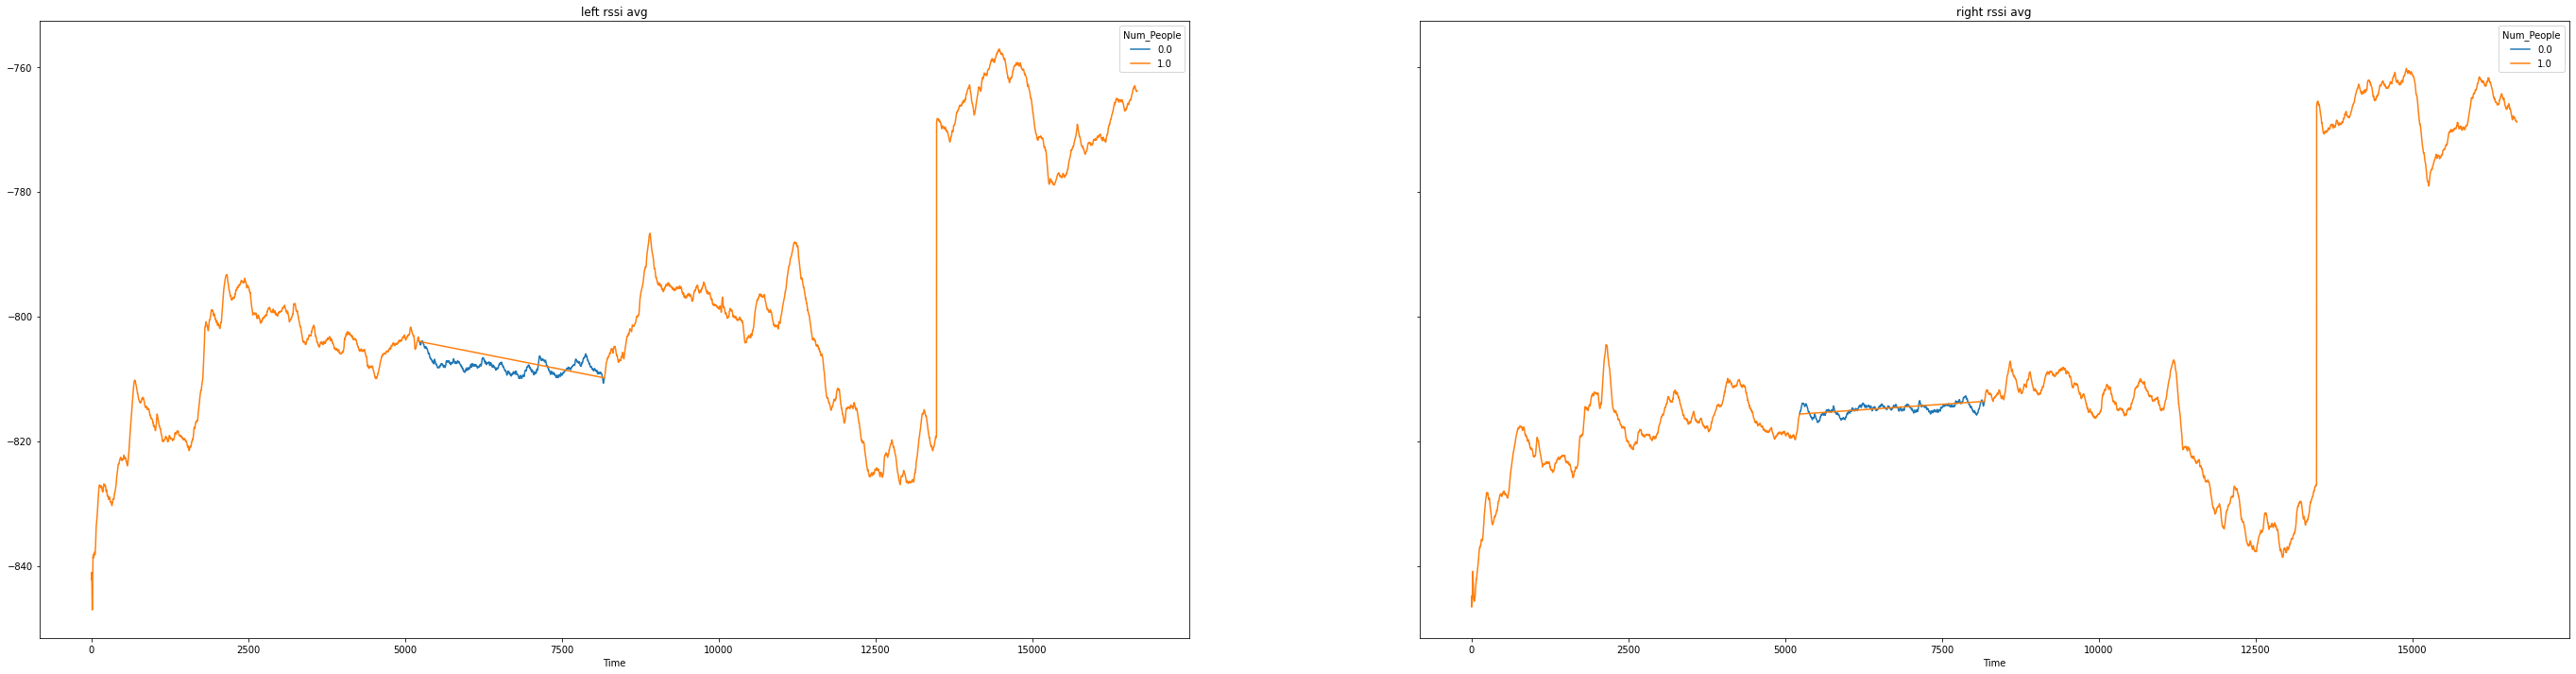

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(48, 12))

number_of_readings = room['Time'].unique().shape[0]
left_avg = np.zeros(number_of_readings)
right_avg = np.zeros(number_of_readings)

index = 0
for name, group in room.groupby('Device_ID'):
    group['RSSI_Left'] = kalman_filter(exponentialSmoothing(group.sort_values('Time')['RSSI_Left']))
    group['RSSI_Right'] = kalman_filter(exponentialSmoothing(group.sort_values('Time')['RSSI_Right']))
    
    # In case not all devies got the same reading length
    right_rssi = np.zeros(right_avg.shape[0])
    left_rssi = np.zeros(left_avg.shape[0])
    right_rssi[:group.shape[0]] = group['RSSI_Left'].to_numpy()
    left_rssi[:group.shape[0]] = group['RSSI_Right'].to_numpy()
    
    left_avg += left_rssi
    right_avg += right_rssi
    index += 1

seaborn.lineplot(ax=axes[0], x=group['Time'], y=left_avg, hue=group['Num_People']).set_title('left rssi avg')
seaborn.lineplot(ax=axes[1], x=group['Time'], y=right_avg, hue=group['Num_People']).set_title('right rssi avg')